In [1]:
from plurals.agent import Agent
from plurals.deliberation import Chain, Debate, Ensemble
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
import pandas as pd
import sys 
from tqdm import tqdm
import os
from dotenv import load_dotenv


load_dotenv(dotenv_path="../src/.env")

os.environ['OPENAI_API_KEY'] = os.getenv("OPENAI_API_KEY", "")
os.environ['ANTHROPIC_API_KEY'] = os.getenv("ANTHROPIC_API_KEY", "")


sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from helpers import *
import lexical_diversity

import numpy as np
from sklearn.metrics import pairwise_distances
from sentence_transformers import SentenceTransformer


mypal = make_aesthetic(with_gridlines=False)

/Users/jashkina/Documents/LocResearch/plurals_system_paper/plurals_system_paper/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jashkina/Documents/LocResearch/plurals_system_paper/plurals_system_paper/venv/lib/python3.9/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# Compute Metrics

In [2]:
import numpy as np
import pandas as pd
import nltk
from nltk.util import ngrams
from sklearn.utils import resample
import joblib
from tqdm.auto import tqdm
from lexical_diversity import lex_div as ld
import os

def generate_ngrams(text, ngram_lengths, cut_at=None):
    """
    Generates ngrams for a given text and ngram lengths using nltk word_tokenize.

    Args:
        text (str): The text to generate ngrams for.
        ngram_lengths (list): A list of integers specifying the ngram lengths to generate.
        
    Returns:
        list: A list of ngrams for the given text and ngram lengths.
    """
    words = nltk.word_tokenize(text)
    if cut_at:
        words = words[:cut_at]
    return [' '.join(ngram) for n in ngram_lengths for ngram in ngrams(words, n)]

def type_token_ratio(units):
    """
    Returns the type-token ratio for a list of units, which is the number of unique units divided by the total number of units.

    Args:
        units (list): A list of units (words or ngrams).

    Returns:
        float: The type-token ratio.
    """
    return len(set(units)) / len(units)


def compute_diversity_metrics(grams):
    """
    Compute diversity metrics for multiple n-grams.

    Args:
        grams (dict): A dictionary with n-gram counts for each n-gram level.

    Returns:
        list: A list of dictionaries with metrics results.
    """
    results = []
    for n, gram_data in grams.items():
        ttr = type_token_ratio(gram_data)
        results.append({'metric': f'TTR-{n}', 'mean':ttr})
        hdd = ld.hdd(gram_data)
        results.append({'metric': f'HDD-{n}', 'mean':hdd})
    return results

def process_data(resp_df):
    """
    Apply n-gram generation to DataFrame and compute metrics.

    Args:
        resp_df (DataFrame): A DataFrame with a 'response' column containing text data.

    Returns:
        DataFrame: A DataFrame containing computed metrics.
    """
    ngram_lengths = [1, 2, 3,4,5]
    for n in ngram_lengths:
        resp_df[f'{n}_gram'] = resp_df['response'].apply(lambda x: generate_ngrams(x, [n]))
    
    grouped = resp_df.groupby(['topic', 'agent_type', 'ideology'])
    results = []

    for (topic, agent, ideology), group in grouped:
        grams = {n: [token for sublist in group[f'{n}_gram'] for token in sublist] for n in ngram_lengths}
        metrics = compute_diversity_metrics(grams)
        for metric in metrics:
            metric.update({'topic': topic, 'agent_type': agent, 'ideology': ideology})
            results.append(metric)
    return pd.DataFrame(results)


model_files = {
    "gpt-4o":{'input_fn':"../data/processed/100words_4issues_30iters_gpt-4o_pol_responses.csv"},
    "claude-sonnet":{'input_fn':"../data/processed/100words_4issues_30iters_claude-3-sonnet-20240229_pol_responses.csv"},
}

for model, model_file in model_files.items():
    resp_df = pd.read_csv(model_file['input_fn'])
    final_df = process_data(resp_df)
    final_df['topic2'] = final_df['topic'].apply(lambda x: "LGBT Adoption\nRights" if x == "LGBT Adoption Rights" else x)
    final_df['Agent Type'] = final_df['agent_type'].apply(lambda x: "Plurals ANES Persona" if x == "persona" else "Non-Plurals")
    model_files[model]['final_df'] = final_df
    final_df.to_csv(f"../data/processed/{model}_diversity_metrics.csv", index=False)

# Plot Metrics

/var/folders/gc/36c2knv139jfg23x561mj5xr0000gp/T/ipykernel_95475/1574517132.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.catplot(data=final_df[final_df['metric'].str.contains(metric_type)],
/var/folders/gc/36c2knv139jfg23x561mj5xr0000gp/T/ipykernel_95475/1574517132.py:4: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  ax = sns.catplot(data=final_df[final_df['metric'].str.contains(metric_type)],


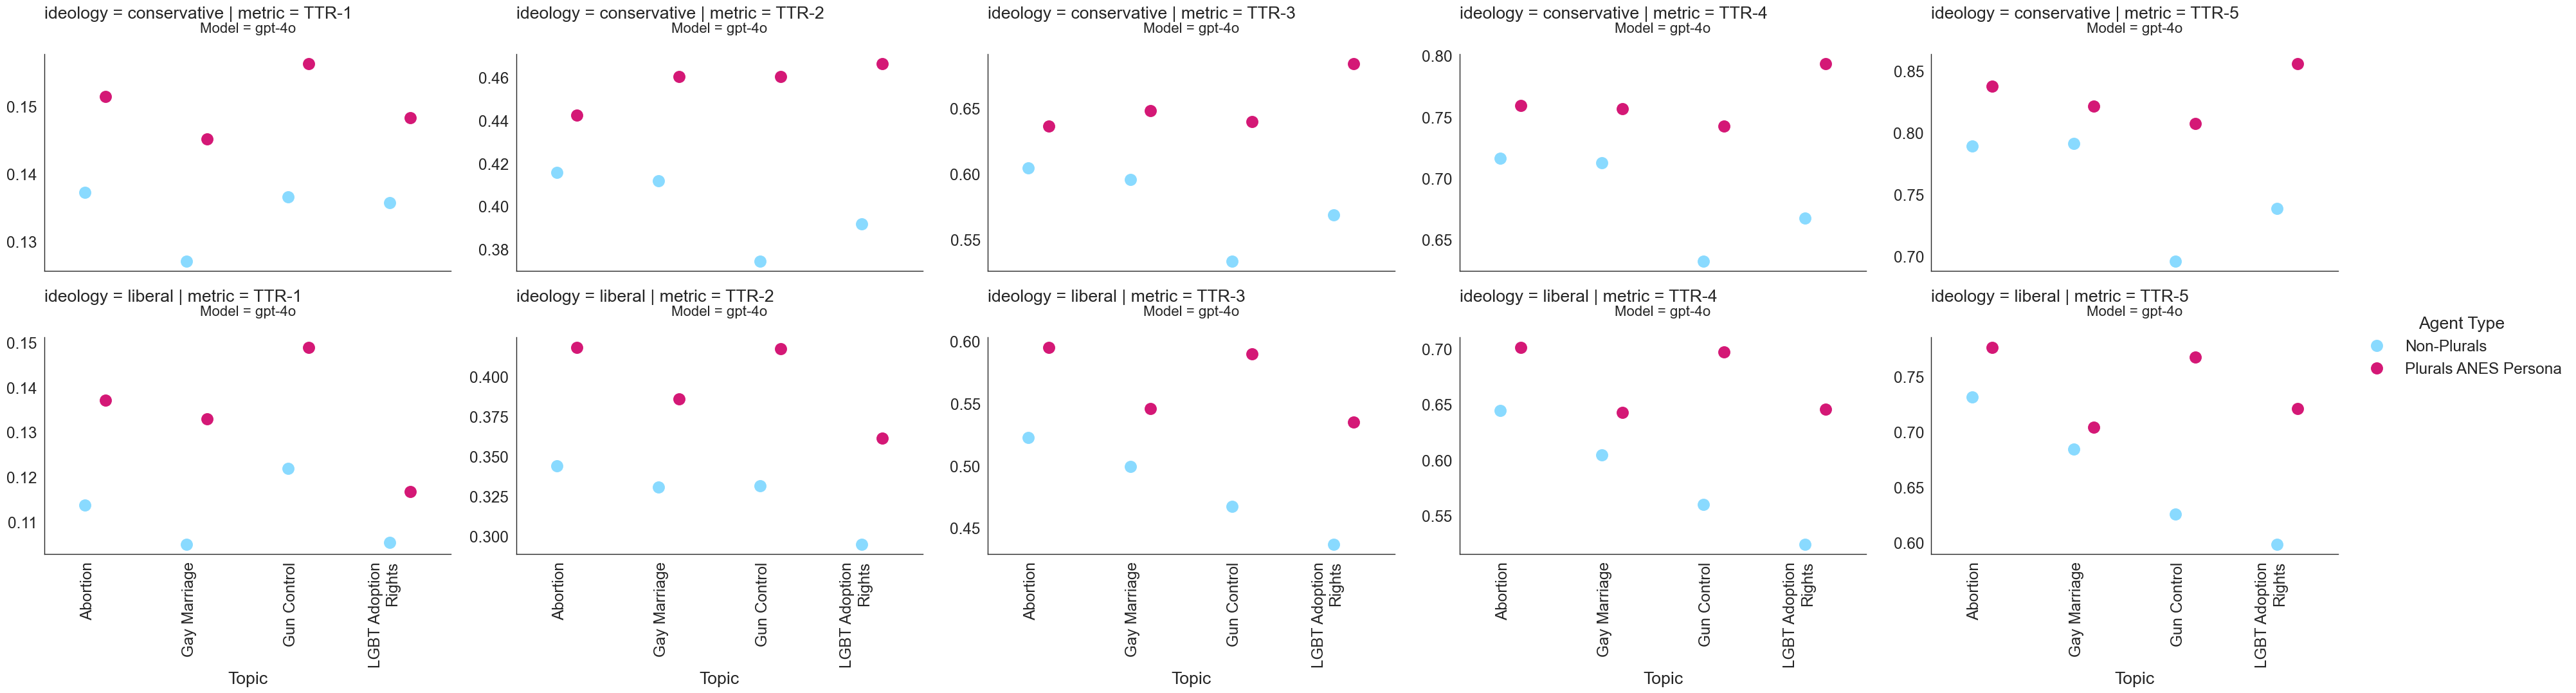

/var/folders/gc/36c2knv139jfg23x561mj5xr0000gp/T/ipykernel_95475/1574517132.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.catplot(data=final_df[final_df['metric'].str.contains(metric_type)],
/var/folders/gc/36c2knv139jfg23x561mj5xr0000gp/T/ipykernel_95475/1574517132.py:4: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  ax = sns.catplot(data=final_df[final_df['metric'].str.contains(metric_type)],


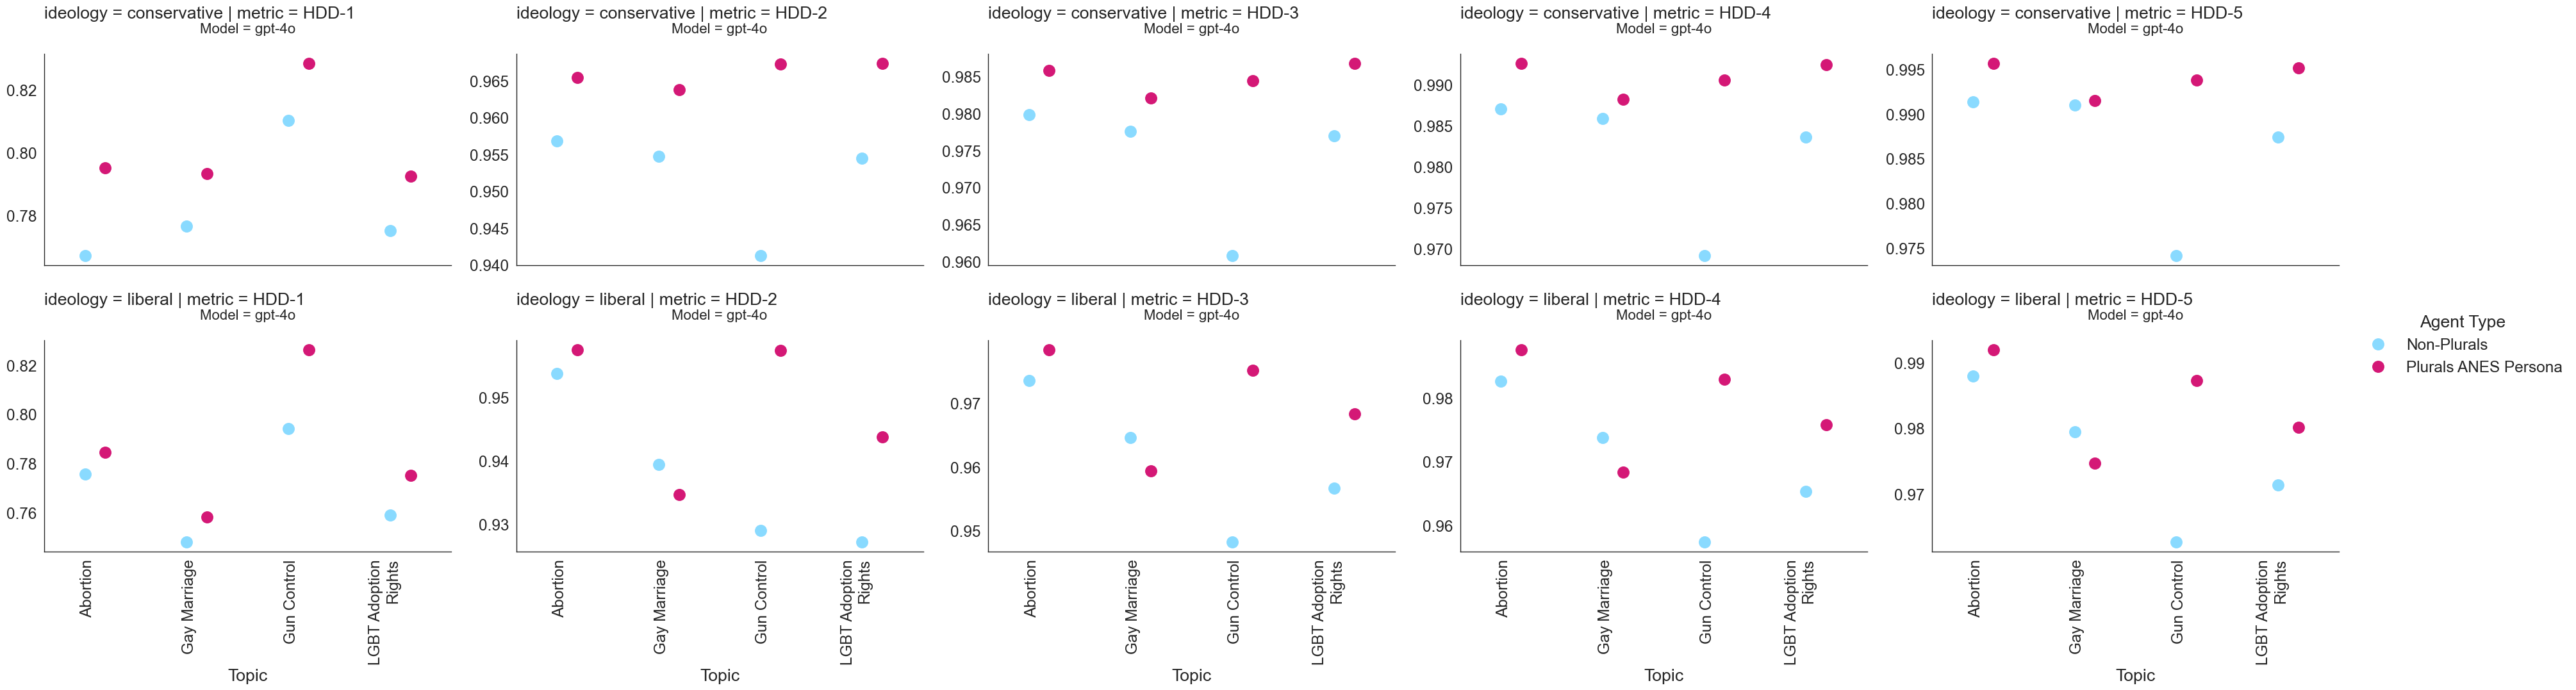

/var/folders/gc/36c2knv139jfg23x561mj5xr0000gp/T/ipykernel_95475/1574517132.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.catplot(data=final_df[final_df['metric'].str.contains(metric_type)],
/var/folders/gc/36c2knv139jfg23x561mj5xr0000gp/T/ipykernel_95475/1574517132.py:4: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  ax = sns.catplot(data=final_df[final_df['metric'].str.contains(metric_type)],


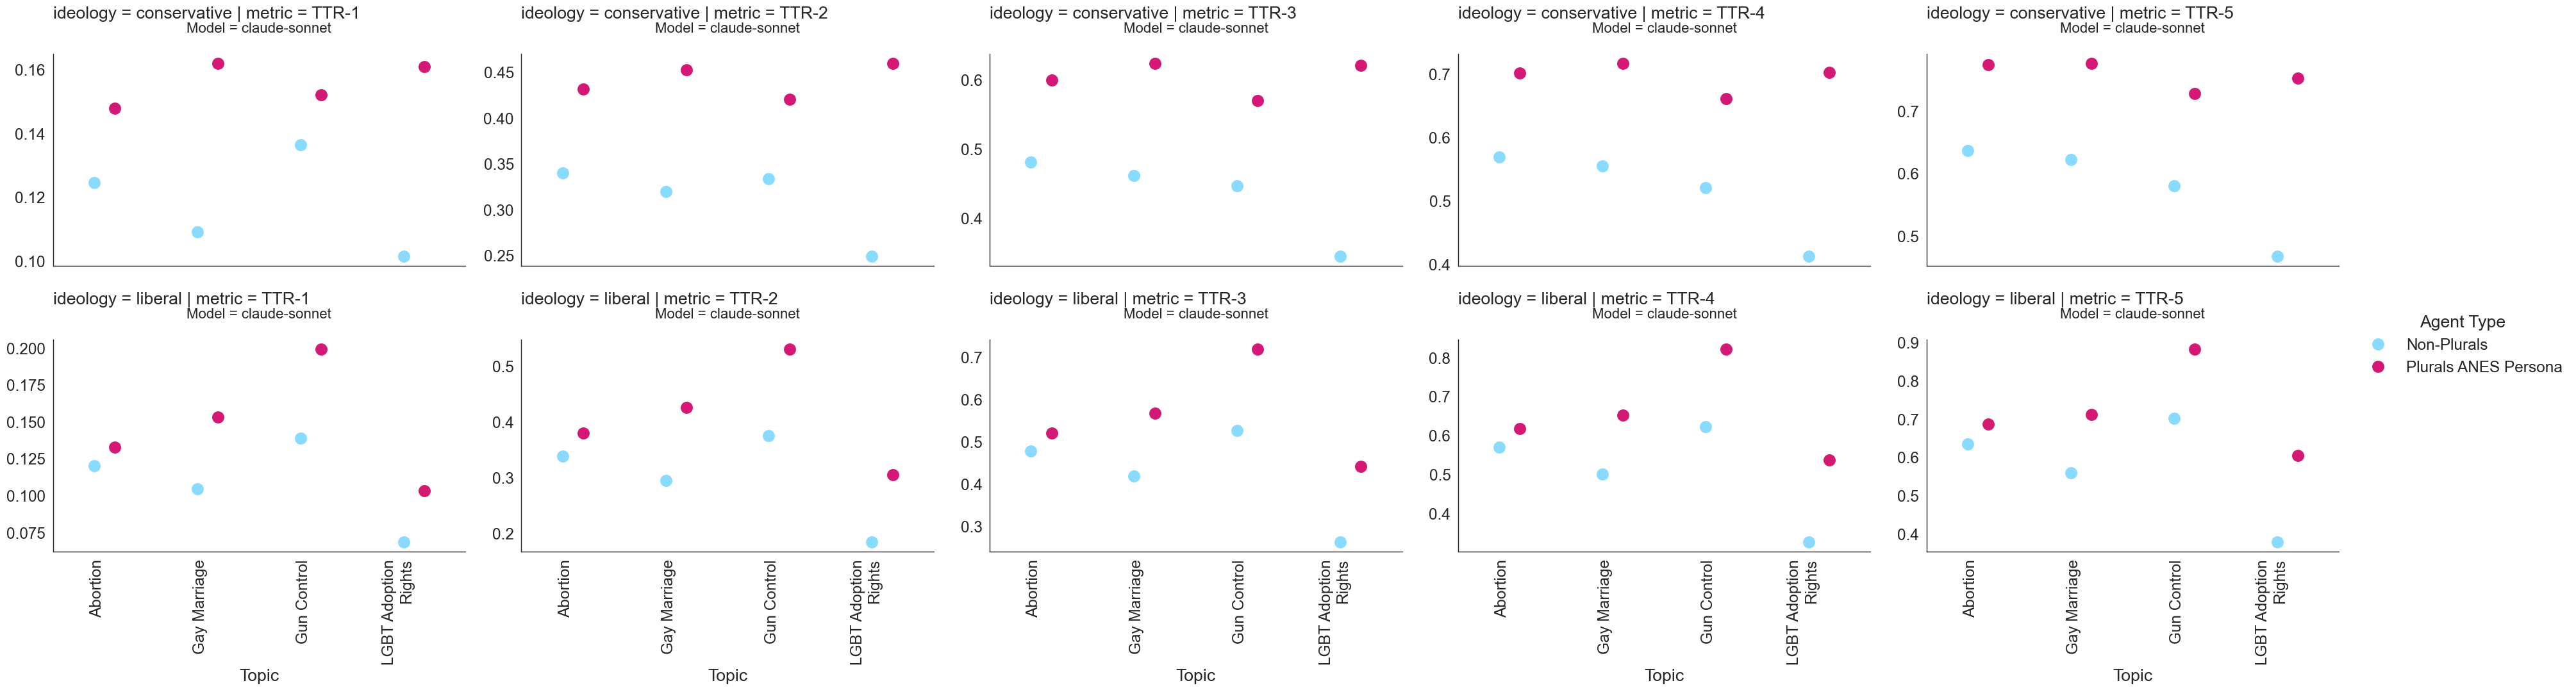

/var/folders/gc/36c2knv139jfg23x561mj5xr0000gp/T/ipykernel_95475/1574517132.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.catplot(data=final_df[final_df['metric'].str.contains(metric_type)],
/var/folders/gc/36c2knv139jfg23x561mj5xr0000gp/T/ipykernel_95475/1574517132.py:4: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  ax = sns.catplot(data=final_df[final_df['metric'].str.contains(metric_type)],


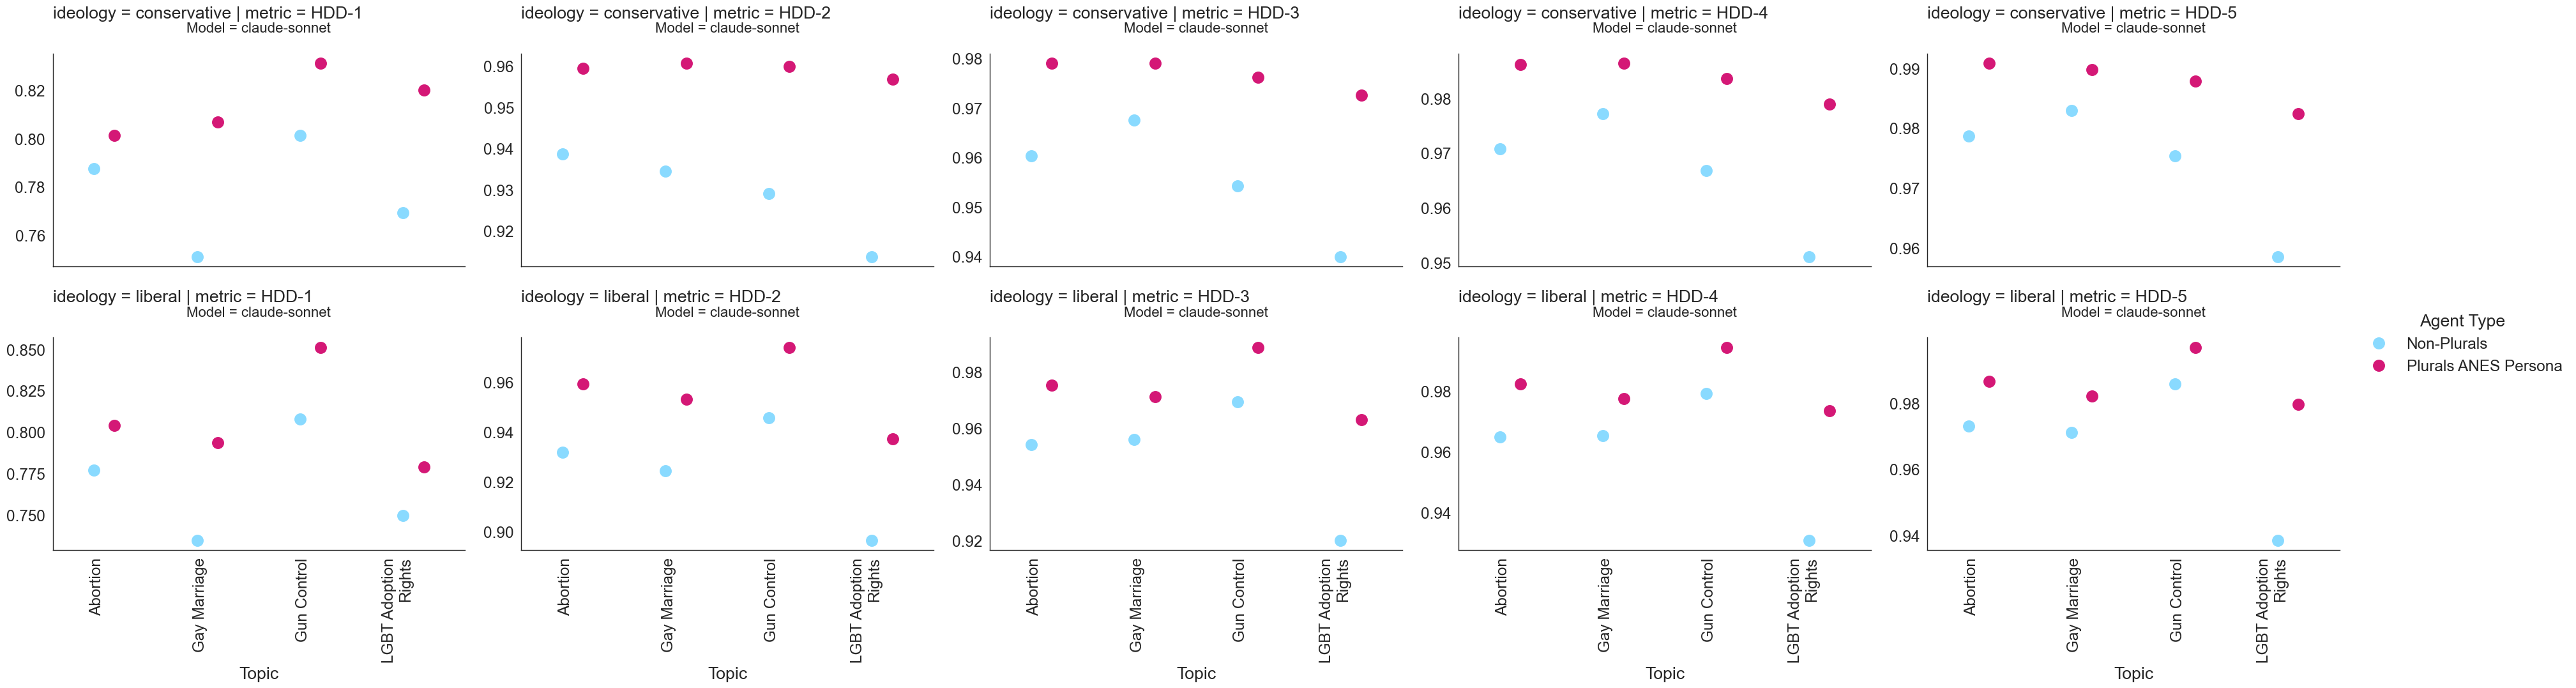

In [3]:
for model, model_file in model_files.items():
    final_df = model_file['final_df']
    for metric_type in ['TTR', 'HDD']:
        ax = sns.catplot(data=final_df[final_df['metric'].str.contains(metric_type)], 
                        y='mean', 
                        x='topic2',
                        kind='point',
                        hue='Agent Type', 
                        col='metric',
                        sharey=False,
                        join=False,
                        markersize=12,
                        row='ideology',
                        aspect=1.5,
                        dodge=0.2,
                        ci=None)


        for ax in ax.axes.flat:
            ax.set_xlabel('Topic')
            ax.set_ylabel('')
            for label in ax.get_xticklabels():
                label.set_rotation(90)
                label.set_ha('right')

            ax.annotate(f"Model = {model}", xy=(0.5, 1.1), xycoords='axes fraction', ha='center', fontsize=16)

        plt.savefig(f"../plots/{model}_lexical_diversity_{metric_type}.pdf", dpi=300, bbox_inches='tight')
        plt.show()


# Statistics

In [5]:
from scipy.stats import binomtest


def df_binom_test(df, success_col, p):
    n = len(df)
    x = df[success_col].sum()
    prop = x / n
    res = binomtest(x, n, p)
    return prop, res

for model, model_file in model_files.items():
    print("*******")
    print("MODEL", model)
    print("*******")
    final_df = model_file['final_df']
    lex_data = []
    metrics = [x for x in final_df['metric'].unique()]
    for topic in final_df['topic'].unique():
        for ideology in final_df['ideology'].unique():
            for metric in metrics:
                tdf = final_df[(final_df['topic'] == topic) & (final_df['ideology'] == ideology)& (final_df['metric'] == metric)]
                plurals_value = tdf[tdf['agent_type'] == 'persona']['mean'].mean()
                non_plurals_value = tdf[tdf['agent_type'] == 'default']['mean'].mean()
                lex_data.append({
                    'topic': topic,
                    'ideology': ideology,
                    'metric': metric,
                    'plurals': plurals_value,
                    'non_plurals': non_plurals_value
                })
    lex_df = pd.DataFrame(lex_data)
    lex_df['greater'] = (lex_df['plurals'] > lex_df['non_plurals']).astype(int)
    lex_df['delta'] = lex_df['plurals'] / lex_df['non_plurals']
    lex_df['metric_type'] = lex_df['metric'].apply(lambda x: x.split("-")[0])

    prop, res =  df_binom_test(lex_df, success_col="greater", p=0.5)
    print("OVERALL TEST")
    print(prop, res)

    for metric_type in ['TTR', 'HDD']:
        print("********")
        print(metric_type, "TEST")
        metric_df = lex_df[lex_df['metric_type'] == metric_type]
        prop, res =  df_binom_test(metric_df, success_col='greater', p=0.5)
        print(prop, res)




    print(lex_df['delta'].describe())
    print(lex_df['greater'].value_counts())
    print(lex_df.groupby(['metric_type'])['greater'].value_counts(normalize=False))
    print("==================================")


*******
MODEL gpt-4o
*******
OVERALL TEST
0.95 BinomTestResult(k=76, n=80, alternative='two-sided', statistic=0.95, pvalue=2.7577887293885173e-18)
********
TTR TEST
1.0 BinomTestResult(k=40, n=40, alternative='two-sided', statistic=1.0, pvalue=1.8189894035458565e-12)
********
HDD TEST
0.9 BinomTestResult(k=36, n=40, alternative='two-sided', statistic=0.9, pvalue=1.8570244719740003e-07)
count    80.000000
mean      1.082437
std       0.086762
min       0.994439
25%       1.010663
50%       1.037295
75%       1.159106
max       1.266200
Name: delta, dtype: float64
greater
1    76
0     4
Name: count, dtype: int64
metric_type  greater
HDD          1          36
             0           4
TTR          1          40
Name: count, dtype: int64
*******
MODEL claude-sonnet
*******
OVERALL TEST
1.0 BinomTestResult(k=80, n=80, alternative='two-sided', statistic=1.0, pvalue=1.6543612251060553e-24)
********
TTR TEST
1.0 BinomTestResult(k=40, n=40, alternative='two-sided', statistic=1.0, pvalue=1.81

# WC Lengths

In [6]:
from scipy.stats import ttest_ind

for model, model_file in model_files.items():
    print("MODEL", model)
    final_df = model_file['final_df']
    resp_df = pd.read_csv(model_file['input_fn'])

    resp_df['wc'] = resp_df['response'].apply(lambda x: len(generate_ngrams(x, [1])))
    persona_wc = resp_df[resp_df['agent_type'] == 'persona']['wc']
    default_wc = resp_df[resp_df['agent_type'] == 'default']['wc']


    plurals_stats = pretty_print_desc_stats(persona_wc, n_digits=1)
    non_plurals_stats = pretty_print_desc_stats(default_wc, n_digits=1)

    t_test = ttest_ind(persona_wc, default_wc)
    t, p = t_test.statistic, t_test.pvalue

    s = (
        f"Differences in word counts for Plurals ({plurals_stats}) and Non-Plurals ({non_plurals_stats}) "
        f"responses were small in magnitude but statistically significant (t({len(persona_wc) + len(default_wc) - 2}) = "
        f"{t:.2f}, p < 0.05)."
    )

    print(s)
    print("===========")


MODEL gpt-4o
Differences in word counts for Plurals ($M = 104.1, Mdn = 104.5, SD = 7.7$) and Non-Plurals ($M = 107.2, Mdn = 108.0, SD = 6.0$) responses were small in magnitude but statistically significant (t(478) = -4.93, p < 0.05).
MODEL claude-sonnet
Differences in word counts for Plurals ($M = 104.6, Mdn = 105.0, SD = 8.5$) and Non-Plurals ($M = 98.1, Mdn = 98.0, SD = 8.2$) responses were small in magnitude but statistically significant (t(478) = 8.54, p < 0.05).


In [ ]:
!pip3 install 